<a href="https://colab.research.google.com/github/spacemonkey1101/mozart_with_tf2.0/blob/master/mozart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from glob import glob 
import tensorflow as tf
from music21 import converter , instrument , note , chord , stream
from tensorflow.keras.layers import Embedding , LSTM, Dense, Dropout , Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
import numpy as np
import matplotlib.pyplot as plt


In [20]:

#we are using a converter class from music21 library to convert our midi data 
#to something the computer can understand
test = converter.parse('/content/drive/My Drive/mozart_midi/mz_311_1.mid')#loading the mozart dataset from my google drive

# parts mean multiple different instruments in a score
parts = instrument.partitionByInstrument(test)
if parts:#if there are multiple instruments it will be divided into parts
  notes_in_song = parts.parts[0].recurse()
else:
  notes_in_song = test.flat.notes
for element in notes_in_song:
  print(element)

Piano
<music21.tempo.MetronomeMark allegrissimo Quarter=141.83>
D major
D major
<music21.meter.TimeSignature 4/4>
<music21.meter.TimeSignature 4/4>
<music21.chord.Chord A4 D5 F#4>
<music21.chord.Chord A2 D2 D3>
<music21.tempo.MetronomeMark Quarter=147.83>
<music21.note.Note G>
<music21.chord.Chord F#4 D4>
<music21.note.Note F#>
<music21.note.Note E>
<music21.note.Note F#>
<music21.note.Note A>
<music21.chord.Chord E4 G4>
<music21.note.Note G>
<music21.tempo.MetronomeMark Quarter=135.83>
<music21.note.Note F#>
<music21.note.Note G>
<music21.tempo.MetronomeMark Quarter=148.83>
<music21.note.Note A>
<music21.chord.Chord A4 F#4>
<music21.tempo.MetronomeMark Quarter=146.83>
<music21.tempo.MetronomeMark Quarter=148.83>
<music21.note.Note A>
<music21.note.Note B>
<music21.tempo.MetronomeMark Quarter=148.83>
<music21.note.Note C#>
<music21.tempo.MetronomeMark molto allegro Quarter=143.83>
<music21.note.Note D>
<music21.tempo.MetronomeMark Quarter=148.83>
<music21.note.Note A>
<music21.note.Not

In [21]:
#load the training data
notes = [] #this will store all the notes
count = 0  #to visibly see the working of data
for file in glob('/content/drive/My Drive/mozart_midi/*.mid'):
  count += 1
  print(count)
  midi = converter.parse(file) 
  
  notes_in_song = None
  
  parts = instrument.partitionByInstrument(midi)

  if parts:
    notes_in_song = parts.parts[0].recurse()
  else:
    notes_in_song = test.flat.notes
  for element in notes_in_song:
    #we will preprocess the data to remove unwanted stuff like tempo,rest etc
    #If we encounter a note we put it in the list in its alphabetic representation 
    #such as ‘C4’, ‘A#3’ etc. If we encounter a chord we put it’s notes in numeric 
    #format separated by a ‘z’ such as ‘9z1z4’, ‘1z3’ etc. 
    if isinstance(element,note.Note): #if instance is a note or not
        notes.append(str(element.pitch))
    elif isinstance(element,chord.Chord): #if instance is a chord
        notes.append('z'.join(str(n) for n in element.normalOrder)) 
        #chords are represented by 'z' + chord num



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [22]:
print(notes)
#this is not a text dataset so we will convert it into a string called music_Sequence

['B4', 'G3', 'D4', 'D5', 'C5', 'B4', 'A4', 'F#3', 'B4', 'G3', 'C5', 'A3', 'D4', 'D5', 'F#3', 'C5', 'G3', 'B4', 'A4', 'G4', '7z0', '4', '7z11', '2', '4z7', '0', '2z7', 'B3', 'C5', 'F#3', 'A4', 'B4', 'G3', 'G4', '7z11', 'D3', '6z9', 'B4', 'G3', 'D4', 'D5', 'C5', 'B4', 'A4', 'F#3', 'B4', 'G3', 'C5', 'D4', 'A3', 'E5', 'F#3', 'D5', 'C5', 'G3', 'B4', 'A4', 'G4', '7z0', '4', '7z11', '2', 'E5', 'G4', '0', 'F#5', 'G5', 'C5', '0z4', 'B4', 'G4', 'D4', '9z11', 'F#4', '9z11', '9z11', '7z9', 'A4', 'G4', 'G3', 'B3', 'D4', 'B3', 'B4', 'C3', 'E3', 'A4', 'A3', 'E3', 'G4', 'D3', 'F#4', 'C4', 'F#4', 'A3', 'D4', 'C4', 'B4', 'G3', 'B3', 'D4', 'B3', 'G4', 'E3', 'G3', '7z9', 'B3', '7z9', '7z9', '6z7', 'G3', 'G4', 'B4', 'C3', 'A4', 'E3', 'A4', 'A3', 'E3', 'G4', 'D3', 'F#4', 'C4', 'F#4', 'A3', 'D4', 'C4', 'B4', 'G3', 'D4', 'D5', 'C5', 'B4', 'A4', 'F#3', 'B4', 'G3', 'C5', 'D4', 'A3', 'D5', 'F#3', 'C5', 'G3', 'B4', 'A4', 'G4', '7z0', '4', '7z11', '2', '4z7', '0', '2z7', 'B3', 'C5', 'F#3', 'A4', 'B4', 'G3', 'G4', 

In [23]:
#Tokening each notes and chords to an integer

music_sentence = [" ".join(str(item) for item in notes)]

print(music_sentence)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(music_sentence)
total_classes = len(tokenizer.word_index)+1
print(total_classes)
sequence = tokenizer.texts_to_sequences(music_sentence)[0]
print(sequence)

['B4 G3 D4 D5 C5 B4 A4 F#3 B4 G3 C5 A3 D4 D5 F#3 C5 G3 B4 A4 G4 7z0 4 7z11 2 4z7 0 2z7 B3 C5 F#3 A4 B4 G3 G4 7z11 D3 6z9 B4 G3 D4 D5 C5 B4 A4 F#3 B4 G3 C5 D4 A3 E5 F#3 D5 C5 G3 B4 A4 G4 7z0 4 7z11 2 E5 G4 0 F#5 G5 C5 0z4 B4 G4 D4 9z11 F#4 9z11 9z11 7z9 A4 G4 G3 B3 D4 B3 B4 C3 E3 A4 A3 E3 G4 D3 F#4 C4 F#4 A3 D4 C4 B4 G3 B3 D4 B3 G4 E3 G3 7z9 B3 7z9 7z9 6z7 G3 G4 B4 C3 A4 E3 A4 A3 E3 G4 D3 F#4 C4 F#4 A3 D4 C4 B4 G3 D4 D5 C5 B4 A4 F#3 B4 G3 C5 D4 A3 D5 F#3 C5 G3 B4 A4 G4 7z0 4 7z11 2 4z7 0 2z7 B3 C5 F#3 A4 B4 G3 G4 7z11 D3 6z9 B4 D4 G3 D5 C5 B4 A4 F#3 B4 G3 C5 A3 D4 E5 F#3 D5 C5 G3 B4 A4 G4 7z0 4 7z11 2 E5 G4 0 F#5 G5 C5 0z4 B4 D4 G4 9z11 F#4 9z11 9z11 7z9 A4 G4 G3 B3 D4 B3 B4 C3 E3 A4 A3 E3 G4 D3 F#4 C4 F#4 A3 D4 C4 B4 G3 B3 D4 B3 G4 E3 G3 7z9 B3 7z9 7z9 6z7 G3 G4 B4 C3 A4 E3 A4 A3 E3 G4 D3 F#4 C4 F#4 A3 D4 C4 G4 7z11 E-4 6z9z11 E-4 6z9z11 E4 4z7 F#4 G4 E4 D4 4z7z9 C#4 C#4 4z7z9 A3 A4 2z6 2z8 11 2z8 11 2z8 11 9z1 4z9 9z1 4z9 9z1 4z9 6z7 4z6 F#5 G5 A5 D4 F#4 A5 A4 F#4 D4 A5 F#4 9z11 A4 8z

In [48]:
#looking at the word vectors as the words are mapped
word_ind = tokenizer.word_index
print(word_ind)

{'5': 1, '4': 2, 'b': 3, 'd5': 4, '3': 5, 'c5': 6, 'e': 7, 'e5': 8, 'g5': 9, 'f5': 10, 'c4': 11, 'c': 12, 'a4': 13, 'g4': 14, 'd4': 15, 'f': 16, 'e4': 17, 'a3': 18, 'a5': 19, 'g': 20, 'g3': 21, 'f4': 22, 'b4': 23, 'f3': 24, 'b3': 25, 'c6': 26, 'e3': 27, 'b5': 28, 'd3': 29, 'c3': 30, 'd6': 31, '2': 32, '6': 33, 'a2': 34, '0z4': 35, '4z7': 36, '11z2': 37, '2z5': 38, '9z1': 39, '5z9': 40, '9z0': 41, '3z7': 42, '7z10': 43, '9': 44, '10z2': 45, 'g2': 46, '0z3': 47, '2z6': 48, '7z11': 49, '6z9': 50, '1z4': 51, 'e6': 52, 'b2': 53, '8z11': 54, '7z0': 55, '5z8': 56, '0': 57, 'f6': 58, 'f2': 59, '4z9': 60, '11': 61, '7': 62, '8z0': 63, '9z1z4': 64, '10z0': 65, 'e2': 66, '2z7': 67, '5z10': 68, '9z11': 69, '4z8': 70, '5z7': 71, '10': 72, '5z9z0': 73, '9z2': 74, '11z4': 75, '10z1': 76, '1': 77, '2z6z9': 78, '8': 79, '2z4': 80, '2z8': 81, 'd2': 82, '0z5': 83, '0z4z7': 84, '3z6': 85, '10z3': 86, '7z9': 87, '10z2z5': 88, '2z5z9': 89, '4z10': 90, '3z8': 91, '0z2': 92, '9z0z2': 93, '4z6': 94, '4z8z11': 

In [24]:
#after tokenizing we need to covert it into a sequence
sequence_len = 100 #how many input nodes in a NN

#we separate our data into 2 parts
network_in =[]
network_out =[]

#our wmodel will take 100 tokens and map the 101st token as 
#the answer to the 100 tokens
for i in range(0, len(sequence) - sequence_len):
  sequence_in = sequence[i:i+sequence_len]
  sequence_out = sequence[i+sequence_len]
  network_in.append(sequence_in)
  network_out.append(sequence_out)

In [25]:
network_in = np.array(network_in) 

#output is converted to a one hot encoded labels
label = ku.to_categorical(network_out,total_classes)
np.shape(label)

(71641, 180)

In [27]:
#making the model
model = Sequential()
#we will feed our input into an embedding layer(keras)
#basically words to vector
#This layer takes our input and embeds it onto a dense vector. 
#There are many popular methods of learning word embedding (considering our notes and chords to be words) such as word2vec and GloVe). 
model.add(Embedding(total_classes,100,input_length=sequence_len))#total classes = 180

#Bidirectional LSTM are an extension of traditional LSTMs that can improve model
#performance on sequence classification problems. In problems where all timesteps 
#of the input sequence are available, Bidirectional LSTMs train two instead of
#one LSTMs on the input sequence. The first on the input sequence as-is and the
#second on a reversed copy of the input sequence. This can provide additional 
#context to the network and result in faster and even fuller learning on the problem
model.add(Bidirectional(LSTM(150,return_sequences=True)))

#Dropout: A simple and powerful regularization technique for neural networks and 
#deep learning models. We use it here to prevent overfitting.
model.add(Dropout(0.2))
model.add(LSTM(100))

#dense layer
model.add(Dense(total_classes/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          18000     
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 300)          301200    
_________________________________________________________________
dropout (Dropout)            (None, 100, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 90)                9090      
_________________________________________________________________
dense_1 (Dense)              (None, 180)               16380     
Total params: 505,070
Trainable params: 505,070
Non-trainable params: 0
________________________________________________

In [ ]:
history = model.fit(network_in,label,epochs=100,batch_size=512,verbose=1)




Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Models/epoch100Test/assets


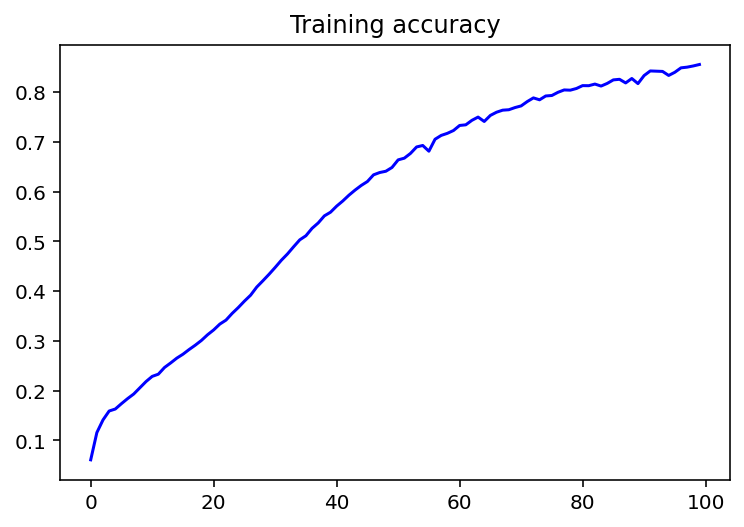

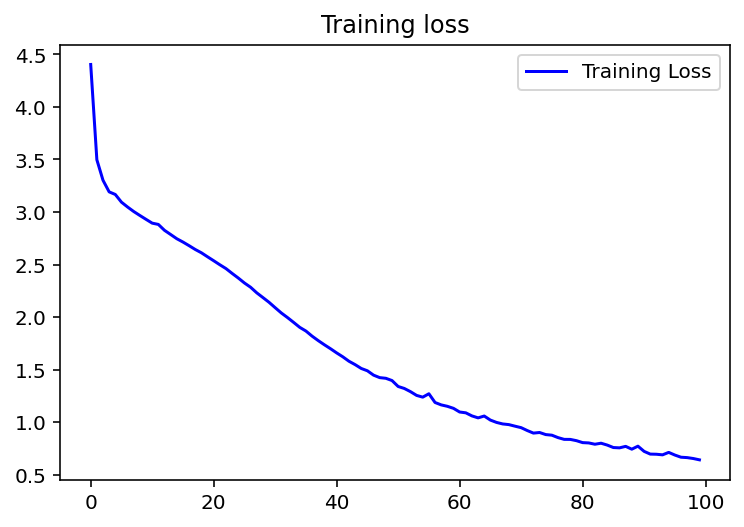

In [33]:
model.save('Models/epoch100Test')
acc = history.history['accuracy']

loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')

plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')

plt.legend()
plt.show()

Epoch 1/200
280/280 [==============================] - 15s 54ms/step - loss: 0.5139 - accuracy: 0.8744
Epoch 2/200
280/280 [==============================] - 15s 55ms/step - loss: 0.4855 - accuracy: 0.8830
Epoch 3/200
280/280 [==============================] - 15s 54ms/step - loss: 0.4766 - accuracy: 0.8860
Epoch 4/200
280/280 [==============================] - 15s 53ms/step - loss: 0.4797 - accuracy: 0.8836
Epoch 5/200
280/280 [==============================] - 15s 53ms/step - loss: 0.4917 - accuracy: 0.8804
Epoch 6/200
280/280 [==============================] - 15s 54ms/step - loss: 0.4839 - accuracy: 0.8829
Epoch 7/200
280/280 [==============================] - 15s 54ms/step - loss: 0.5358 - accuracy: 0.8670
Epoch 8/200
280/280 [==============================] - 15s 54ms/step - loss: 0.5099 - accuracy: 0.8736
Epoch 9/200
280/280 [==============================] - 15s 54ms/step - loss: 0.4845 - accuracy: 0.8820
Epoch 10/200
280/280 [==============================] - 15s 53ms/step - l

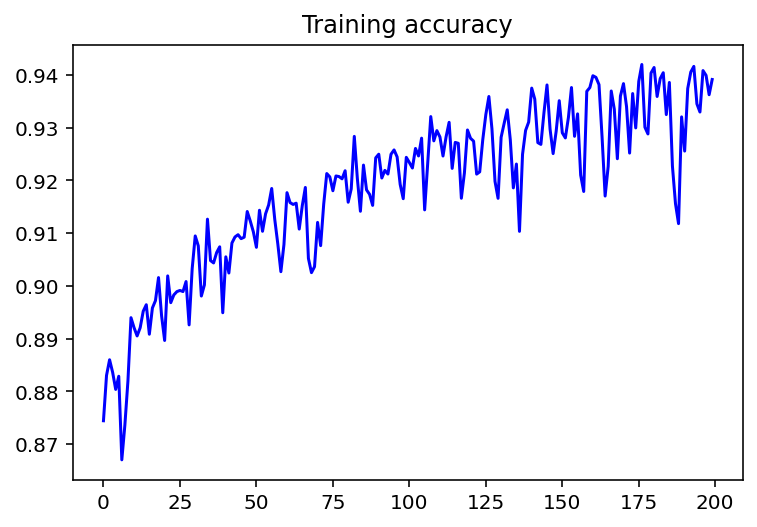

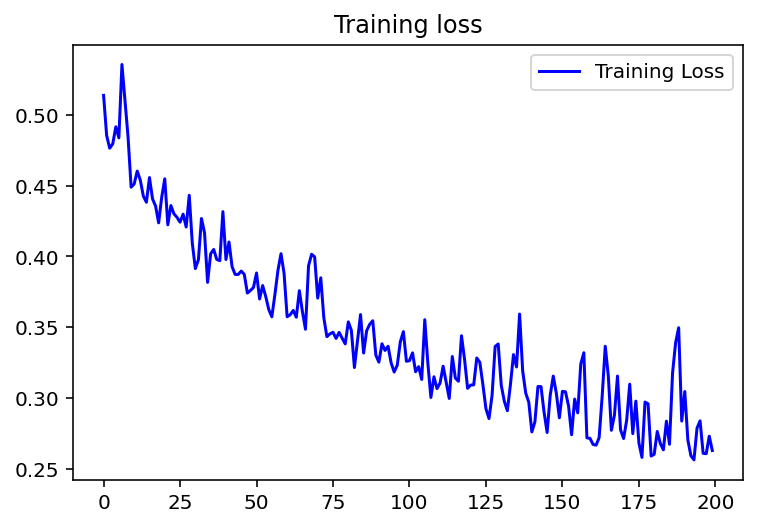

In [49]:
#smaller bach but for 200 epochs
history = model.fit(network_in,label,epochs=200,batch_size=256,verbose=1)
model.save('Models/epoch200Test')
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [50]:
#generating the music
#coverting back to .mid so that we can listen to it

note_to_int = tokenizer.word_index

int_to_note = {v:k for k,v in note_to_int.items()}

#We take a random starting point as a seed for generating new sequence
start = np.random.randint(0,len(network_in)-1)

pattern = network_in[start]

prediction_output = []

#running 500 cycles == 2mins of running time
for i in range(500):
  prediction_in = np.reshape(pattern,(1,len(pattern),1 ))  
  prediction = model.predict(prediction_in,verbose=0)  
  
  #index of our prediction with max probability
  pred_index = np.argmax(prediction)
  
  #convert the resut to notes or chords
  result = int_to_note[pred_index]
  
  prediction_output.append(result)  
  pattern = np.append(pattern,pred_index)
  pattern = pattern[1:len(pattern)]

In [51]:
offset = 0 #offset is time between 2 notes
output_notes = []
for pattern in prediction_output:
  if('z' in pattern) or pattern.isdigit():
    notes_in_chord = pattern.split('z')#if its a chord
    notes = []
    for curr_note in notes_in_chord:
      new_note = note.Note(int(curr_note))
      new_note.storedInstrument = instrument.Piano()
      notes.append(new_note)
    new_chord=chord.Chord(notes)
    new_chord.offset = offset
    output_notes.append(new_chord)
  else: #if its a note
    new_note=note.Note(pattern)
    new_note.offset=offset
    new_note.storedInstrument = instrument.Piano()
    output_notes.append(new_note)
  offset += 0.5

  
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi',fp='/content/drive/My Drive/epoch200Mozart2.mid')

'/content/drive/My Drive/epoch200Mozart2.mid'